In [2]:
import pandas as pd
from dask import dataframe as dd
import numpy as np

/usr/local/lib/python3.9/site-packages/dask/dataframe/utils.py:361: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/usr/local/lib/python3.9/site-packages/dask/dataframe/utils.py:361: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/usr/local/lib/python3.9/site-packages/dask/dataframe/utils.py:361: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)


In [3]:
# # some_file.py
# import sys
# # caution: path[0] is reserved for script path (or '' in REPL)
# sys.path.insert(1, '/Users/cynthiazeng/Dropbox (MIT)/flood/data/')


In [4]:
# #read csv using pandas  -> very slow  
# df = pd.read_csv('/Users/cynthiazeng/Dropbox (MIT)/flood/data/FimaNfipPolicies.csv')

In [5]:
#read csv using dask 
df = dd.read_csv('/Users/cynthiazeng/Dropbox (MIT)/flood/data/FimaNfipPolicies.csv',  
                 dtype={'cancellationDateOfFloodPolicy': 'object',
       'countyCode': 'float64',
       'numberOfFloorsInTheInsuredBuilding': 'float64',
       'occupancyType': 'float64',
       'policyTermIndicator': 'float64',
       'reportedZipCode': 'float64',
       'totalBuildingInsuranceCoverage': 'float64',
       'totalContentsInsuranceCoverage': 'float64',
       'totalInsurancePremiumOfThePolicy': 'float64'})

In [6]:
df.columns

Index(['agricultureStructureIndicator', 'baseFloodElevation',
       'cancellationDateOfFloodPolicy', 'censusTract', 'condominiumIndicator',
       'construction', 'countyCode', 'crsClassCode',
       'deductibleAmountInBuildingCoverage',
       'deductibleAmountInContentsCoverage', 'elevationCertificateIndicator',
       'elevationDifference', 'federalPolicyFee', 'floodZone',
       'hfiaaSurcharge', 'houseOfWorshipIndicator', 'latitude',
       'locationOfContents', 'longitude', 'lowestAdjacentGrade',
       'lowestFloorElevation', 'nonProfitIndicator', 'obstructionType',
       'occupancyType', 'originalConstructionDate', 'originalNBDate',
       'policyCost', 'policyCount', 'policyEffectiveDate',
       'policyTermIndicator', 'postFIRMConstructionIndicator',
       'primaryResidenceIndicator', 'propertyState', 'reportedZipCode',
       'rateMethod', 'regularEmergencyProgramIndicator', 'reportedCity',
       'smallBusinessIndicatorBuilding', 'totalBuildingInsuranceCoverage',
       

In [7]:
#small df with just 1000 samples 
dff= df.head(900000)
print(dff.shape)
print(len(dff['propertyState'].unique()))
print(len(dff['reportedZipCode'].unique()))

(228664, 46)
54
6704


/usr/local/lib/python3.9/site-packages/dask/dataframe/core.py:6297: UserWarning: Insufficient elements for `head`. 900000 elements requested, only 228664 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(msg.format(n, len(r)))


In [8]:
#convert to datetime format 
dff['policyEffectiveDate'] = pd.to_datetime(dff['policyEffectiveDate'])
dff['policyTerminationDate'] = pd.to_datetime(dff['policyTerminationDate'])

#Q: should I use termination year or effective year to be the year? 
# dff['year'] = dff['policyEffectiveDate'].dt.year
dff['year'] = dff['policyTerminationDate'].dt.year

In [9]:
dff.groupby(['propertyState','year']).agg({'totalInsurancePremiumOfThePolicy':'sum'})

totalInsurancePremiumOfThePolicy
propertyState year                                  
AK            2010                            2628.0
              2011                            3127.0
              2012                            3386.0
              2013                            1566.0
              2014                            7343.0
...                                              ...
WY            2017                            1853.0
              2018                            2365.0
              2019                            3574.0
              2020                            3123.0
              2022                            2377.0

[777 rows x 1 columns]

In [22]:
#let's examine demand
#choose one state MA
df1 = dff.loc[dff['propertyState']=='LA']
print(df1.shape)

(25011, 47)


In [23]:
import matplotlib.pyplot as plt
# df1.groupby(['year']).agg({'totalInsurancePremiumOfThePolicy':['sum','count','mean']})
agg = df1.groupby(['year']).agg({'totalInsurancePremiumOfThePolicy':['sum','count','mean']})
agg.columns = ['sum','count','mean'] 

In [24]:
#disregard the first and last year due to insufficient data 
agg = agg.iloc[1:-1]

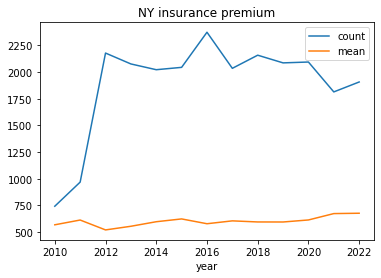

In [25]:
#plot the count and mean of insurance premium over years 
agg['count'].plot()
agg['mean'].plot()
plt.title('NY insurance premium')
plt.legend()

<AxesSubplot:title={'center':'FL insurance premium'}, xlabel='year'>

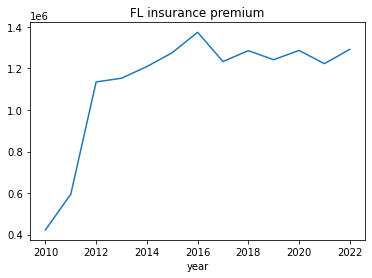

In [26]:
agg['sum'].plot(title='FL insurance premium')

-0.7831810349148822


Text(0.5, 0, 'Annual of policy premium (USD)')

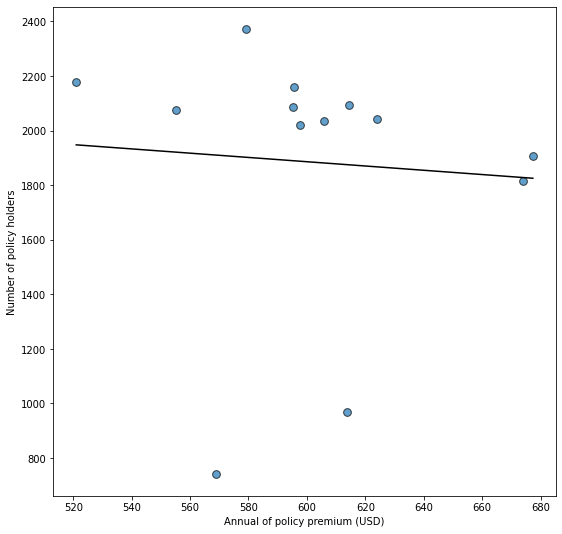

In [29]:
# # plt.scatter(agg)
# plt.scatter(x = agg['mean'], y= agg['count'])

#estimate the decline 

# Initialize layout
fig, ax = plt.subplots(figsize = (9, 9))

# Add scatterplot
ax.scatter(x = agg['mean'], y= agg['count'], s=60, alpha=0.7, edgecolors="k")

# Fit linear regression via least squares with numpy.polyfit
# It returns an slope (b) and intercept (a)
# deg=1 means linear fit (i.e. polynomial of degree 1)
b, a = np.polyfit(x = agg['mean'], y= agg['count'], deg=1)

# Create sequence of 100 numbers from 0 to 100 
xseq = np.linspace(agg['mean'].min(),agg['mean'].max(), num=100)

# Plot regression line
ax.plot(xseq, a + b * xseq, color="k", lw=1.5);

print(b)

# plt.title('Insurance count vs. Mean scatter plot for LA')
plt.ylabel('Number of policy holders')
plt.xlabel('Annual of policy premium (USD)')
# plt.savefig('figs_insur/demand_plot_NY.png')


MA
-7.000993542872989e-05
LA
-0.0003300383627959889
NY
-0.0003297216969004782
TX
-0.002005388707151796


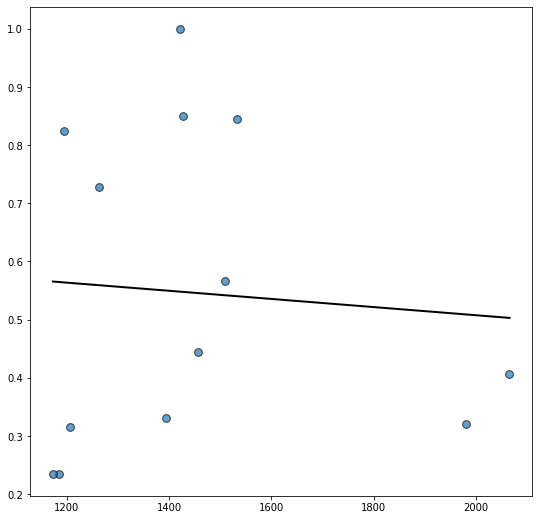

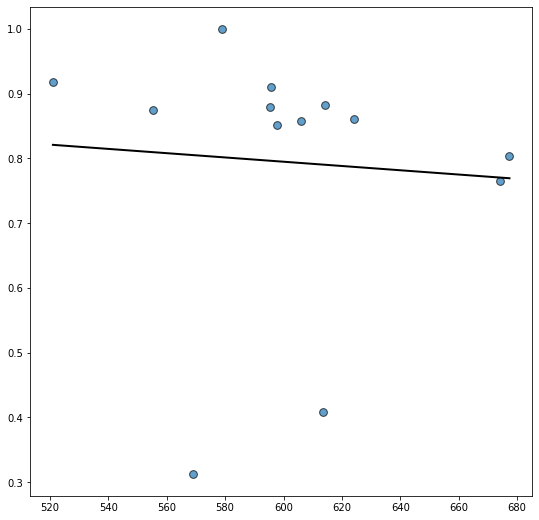

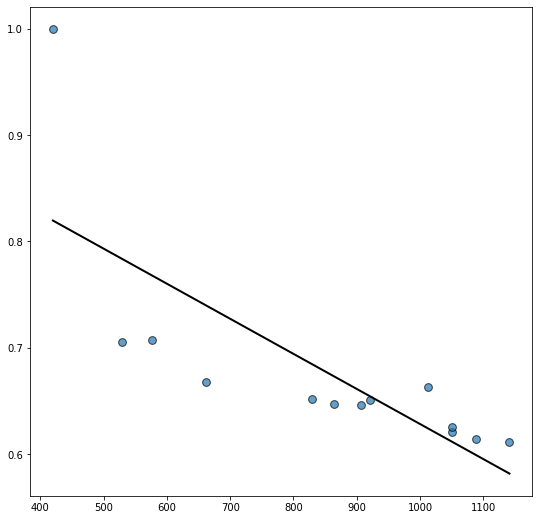

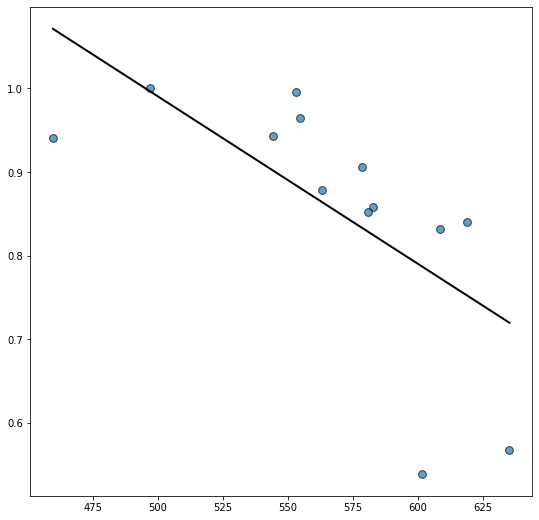

In [31]:
#estimate demand damping in a loop: 
#let's examine demand
for state in['MA','LA','NY','TX']: 
    print(state)
    #choose one state MA
    df1 = dff.loc[dff['propertyState']== state]

    agg = df1.groupby(['year']).agg({'totalInsurancePremiumOfThePolicy':['sum','count','mean']})
    agg.columns = ['sum','count','mean'] 
    #disregard the first and last year due to insufficient data 
    agg = agg.iloc[1:-1]

    # Initialize layout
    fig, ax = plt.subplots(figsize = (9, 9))

    # Add scatterplot
    ax.scatter(x = agg['mean'], y= agg['count']/agg['count'].max(), s=60, alpha=0.7, edgecolors="k")

    # Fit linear regression via least squares with numpy.polyfit
    # It returns an slope (b) and intercept (a)
    # deg=1 means linear fit (i.e. polynomial of degree 1)
    b, a = np.polyfit(x = agg['mean'], y= agg['count']/agg['count'].max(), deg=1)

    print(b)
    # Create sequence of 100 numbers from 0 to 100 
    xseq = np.linspace(agg['mean'].min(),agg['mean'].max(), num=100)

    # Plot regression line
    ax.plot(xseq, a + b * xseq, color="k", lw=2);



In [43]:
#compute the charged premium for each state over each year 


In [69]:
#convert to datetime format 
# df['policyEffectiveDate'] = pd.to_datetime(df['policyEffectiveDate'])
# dff['policyTerminationDate'] = pd.to_datetime(dff['policyTerminationDate'])
# dff['year'] = dff['policyEffectiveDate'].dt.year

In [65]:
# import datetime
# # dff.loc[dff['policyEffectiveDate'].]
# dff['year'] = dff['policyEffectiveDate'].dt.year

In [209]:
#compute the charged premium for each state over each year 


agg_all = dff.groupby(['propertyState','year']).agg({'totalInsurancePremiumOfThePolicy':['sum','count','mean']})

# Drops second level
agg_all.columns = agg_all.columns.droplevel(0)

agg_all.reset_index()

#save to csv 
agg_all.to_csv('nfip_premium_agg.csv')


In [207]:
pwd

'/Users/cynthiazeng/MIT/flood/nbs/cynthia'

In [ ]:
# #convert to datetime format 
# df['policyEffectiveDate'] = pd.to_datetime(df['policyEffectiveDate'])
# # df['policyTerminationDate'] = pd.to_datetime(ff['policyTerminationDate'])
# df['year'] = df['policyEffectiveDate'].dt.year

In [ ]:
# df.dtypes

In [74]:
ddf = dd.read_csv('/Users/cynthiazeng/Dropbox (MIT)/flood/data/FimaNfipPolicies.csv', 
                 blocksize=1000, 
                 dtype={'cancellationDateOfFloodPolicy': 'object',
       'countyCode': 'float64',
       'numberOfFloorsInTheInsuredBuilding': 'float64',
       'occupancyType': 'float64',
       'policyTermIndicator': 'float64',
       'reportedZipCode': 'float64',
       'totalBuildingInsuranceCoverage': 'float64',
       'totalContentsInsuranceCoverage': 'float64',
       'totalInsurancePremiumOfThePolicy': 'float64'})


# assume that rows are already ordered (so no sorting is needed)
# then can modify the index using the lengths of partitions
cumlens = ddf.map_partitions(len).compute().cumsum()

# # since processing will be done on a partition-by-partition basis, save them
# # individually
# new_partitions = [ddf.partitions[0]]
# for npart, partition in enumerate(ddf.partitions[1:].partitions):
#     partition.index = partition.index + cumlens[npart]
#     new_partitions.append(partition)


Exception ignored in: <function OpenFile.__del__ at 0x1226f65e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/fsspec/core.py", line 123, in __del__
    def __del__(self):
KeyboardInterrupt: 


KeyboardInterrupt: 

In [ ]:
cumlens